In [1]:
%matplotlib inline
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import sys
sys.path.append('../code/')
from resnet import *
import matplotlib.pyplot as plt
import numpy as np

In [8]:
torch.manual_seed(0)
batch_size = 64
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


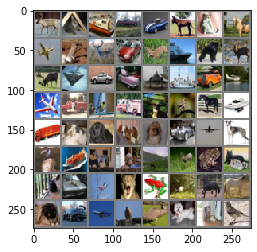

 deer   cat  ship   car


In [9]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [19]:
import torch.optim as optim

Net = resnet34(progress = True, num_classes = 10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Net.parameters(), lr = 1e-3)

if torch.cuda.is_available() :
    Net = Net.cuda('cuda:1')
    print('Model on GPU')

Model on GPU


In [ ]:
acc = 0
num_steps = len(trainset) / batch_size
for epoch in range(100):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        if torch.cuda.is_available() : 
            inputs = inputs.cuda('cuda:1')
            labels = labels.cuda('cuda:1')

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = Net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 500 mini-batches
            print('[%d, %5d / %d] loss: %.3f' %
                  (epoch + 1, i + 1, num_steps, running_loss / 200))
            running_loss = 0.0
            
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            if torch.cuda.is_available() : 
                images = images.cuda('cuda:1')
                labels= labels.cuda('cuda:1')
                
            outputs = Net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    current_acc = (100 * correct / total)
    # saving model for best accuracy
    if acc < current_acc : 
        acc = current_acc
        torch.save(Net.state_dict(), '../saved_models/resnet34_cifar10.pth')
        print('Saving model')

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))